Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


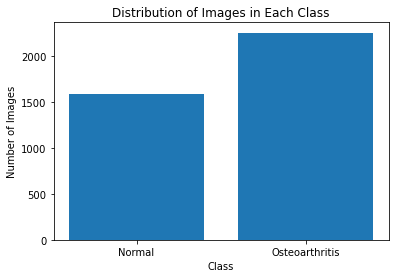

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-22 18:12:48.200390: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 18:12:48.421302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 18:12:48.421364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 18:12:48.455363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 18:12:48.524433: I tensorflow/core/platform/cpu_feature_guar

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


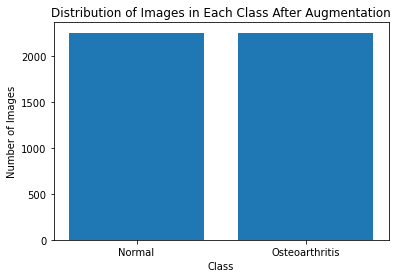

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 1500)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 1500)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 1500 + [1] * 1500  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 1680
X_test size: 900
X_validation size: 420


# MobileNet+Dense

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 11s 190ms/step - loss: 0.6756 - accuracy: 0.6917 - val_loss: 0.3956 - val_accuracy: 0.8286
Epoch 2/50
53/53 [==============================] - 10s 182ms/step - loss: 0.3798 - accuracy: 0.8244 - val_loss: 0.3580 - val_accuracy: 0.8262
Epoch 3/50
53/53 [==============================] - 10s 187ms/step - loss: 0.3090 - accuracy: 0.8589 - val_loss: 0.3769 - val_accuracy: 0.8262
Epoch 4/50
53/53 [==============================] - 10s 188ms/step - loss: 0.2949 - accuracy: 0.8583 - val_loss: 0.3164 - val_accuracy: 0.8476
Epoch 5/50
53/53 [==============================] - 10s 188ms/step - loss: 0.2772 - accuracy: 0.8756 - val_loss: 0.3347 - val_accuracy: 0.8524
Epoch 6/50
53/53 [==============================] - 10s 188ms/step - loss: 0.2263 - accuracy: 0.9155 - val_loss: 0.2932 - val_accuracy: 0.8667
Epoch 7/50
53/53 [==============================] - 10s 193ms/step - loss: 0.2274 - accuracy: 0.9060 - val_loss: 0.3271 - val_accuracy: 0.8524

Validation Loss: 0.27343809604644775
Validation Accuracy: 0.8904761672019958
Test Loss: 0.24756281077861786
Test Accuracy: 0.8955555558204651
Inference Time (Test set): 6.539716005325317 seconds
29/29 [==============================] - 5s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       461
           1       0.89      0.89      0.89       439

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900

Confusion Matrix:
[[415  46]
 [ 48 391]]


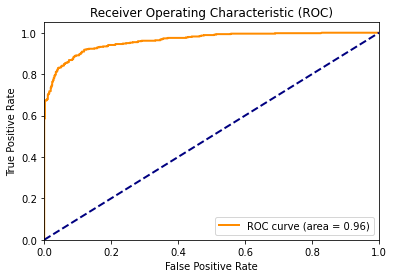

Metrics saved successfully


In [7]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd
# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 11s 199ms/step - loss: 0.1500 - accuracy: 0.9482 - val_loss: 0.2997 - val_accuracy: 0.8714
Epoch 2/100
53/53 [==============================] - 10s 198ms/step - loss: 0.1480 - accuracy: 0.9470 - val_loss: 0.2975 - val_accuracy: 0.8619
Epoch 3/100
53/53 [==============================] - 10s 195ms/step - loss: 0.1356 - accuracy: 0.9470 - val_loss: 0.3064 - val_accuracy: 0.8857
Epoch 4/100
53/53 [==============================] - 10s 192ms/step - loss: 0.1255 - accuracy: 0.9542 - val_loss: 0.2710 - val_accuracy: 0.8952
Epoch 5/100
53/53 [==============================] - 10s 195ms/step - loss: 0.1319 - accuracy: 0.9494 - val_loss: 0.2623 - val_accuracy: 0.9000
Epoch 6/100
53/53 [==============================] - 10s 193ms/step - loss: 0.1255 - accuracy: 0.9548 - val_loss: 0.3003 - val_accuracy: 0.8690
Epoch 7/100
53/53 [==============================] - 10s 190ms/step - loss: 0.0941 - accuracy: 0.9696 - val_loss: 0.2824 - val_accuracy:

Validation Loss: 0.2622933089733124
Validation Accuracy: 0.8999999761581421
Test Loss: 0.2535169720649719
Test Accuracy: 0.8999999761581421
Inference Time (Test set): 6.647735357284546 seconds
29/29 [==============================] - 4s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       461
           1       0.89      0.91      0.90       439

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900

Confusion Matrix:
[[410  51]
 [ 39 400]]


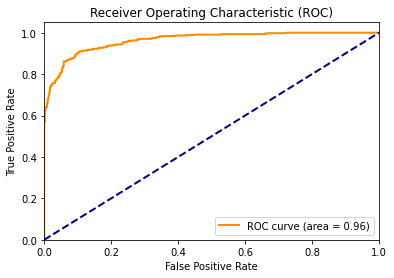

Metrics saved successfully


In [9]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 10s 193ms/step - loss: 0.1034 - accuracy: 0.9607 - val_loss: 0.2868 - val_accuracy: 0.8810
Epoch 2/150
53/53 [==============================] - 10s 192ms/step - loss: 0.0830 - accuracy: 0.9786 - val_loss: 0.2754 - val_accuracy: 0.8857
Epoch 3/150
53/53 [==============================] - 10s 191ms/step - loss: 0.0833 - accuracy: 0.9756 - val_loss: 0.2939 - val_accuracy: 0.8810
Epoch 4/150
53/53 [==============================] - 10s 192ms/step - loss: 0.0755 - accuracy: 0.9732 - val_loss: 0.3004 - val_accuracy: 0.8762
Epoch 5/150
53/53 [==============================] - 10s 191ms/step - loss: 0.0669 - accuracy: 0.9827 - val_loss: 0.3091 - val_accuracy: 0.8738
Epoch 6/150
53/53 [==============================] - 10s 191ms/step - loss: 0.0623 - accuracy: 0.9839 - val_loss: 0.3277 - val_accuracy: 0.8833
Epoch 7/150
53/53 [==============================] - 10s 191ms/step - loss: 0.0713 - accuracy: 0.9720 - val_loss: 0.3459 - val_accuracy:

Validation Loss: 0.27537456154823303
Validation Accuracy: 0.8857142925262451
Test Loss: 0.2660876512527466
Test Accuracy: 0.8933333158493042
Inference Time (Test set): 6.509805917739868 seconds
29/29 [==============================] - 4s 147ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       461
           1       0.88      0.91      0.89       439

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900

Confusion Matrix:
[[405  56]
 [ 40 399]]


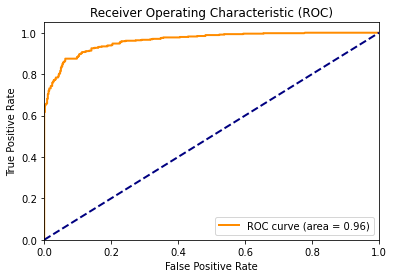

Metrics saved successfully


In [11]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'MObilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")



In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 10s 193ms/step - loss: 0.0927 - accuracy: 0.9661 - val_loss: 0.2903 - val_accuracy: 0.8738
Epoch 2/200
53/53 [==============================] - 10s 192ms/step - loss: 0.0691 - accuracy: 0.9815 - val_loss: 0.3229 - val_accuracy: 0.8714
Epoch 3/200
53/53 [==============================] - 10s 191ms/step - loss: 0.0751 - accuracy: 0.9804 - val_loss: 0.3300 - val_accuracy: 0.8810
Epoch 4/200
53/53 [==============================] - 10s 191ms/step - loss: 0.0607 - accuracy: 0.9833 - val_loss: 0.3951 - val_accuracy: 0.8595
Epoch 5/200
53/53 [==============================] - 10s 192ms/step - loss: 0.0577 - accuracy: 0.9833 - val_loss: 0.3262 - val_accuracy: 0.8690
Epoch 6/200
53/53 [==============================] - 10s 191ms/step - loss: 0.0528 - accuracy: 0.9833 - val_loss: 0.3179 - val_accuracy: 0.8762
Training Time: 60.99603819847107 seconds


Validation Loss: 0.2903459966182709
Validation Accuracy: 0.8738095164299011
Test Loss: 0.2831279933452606
Test Accuracy: 0.8922222256660461
Inference Time (Test set): 6.538210153579712 seconds
29/29 [==============================] - 4s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       461
           1       0.87      0.92      0.89       439

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900

Confusion Matrix:
[[400  61]
 [ 36 403]]


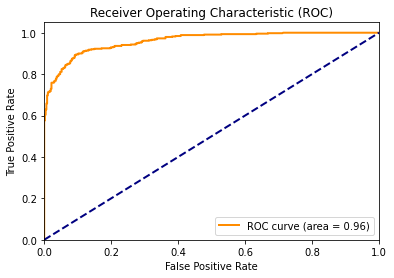

Metrics saved successfully


In [13]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# MobileNet+Dense+Dropout

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add dropout regularization
x = Dropout(0.5)(x)  # Adjust dropout rate as needed

# Define the number of output classes based on your data
num_classes = len(np.unique(y_train))

# Add a final classification layer with softmax activation
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [15]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 11s 196ms/step - loss: 0.7293 - accuracy: 0.5042 - val_loss: 0.7032 - val_accuracy: 0.4857
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.7086 - accuracy: 0.4958 - val_loss: 0.6959 - val_accuracy: 0.4857
Epoch 3/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6969 - accuracy: 0.5089 - val_loss: 0.7008 - val_accuracy: 0.4857
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.7007 - accuracy: 0.5042 - val_loss: 0.7079 - val_accuracy: 0.4857
Epoch 5/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6937 - accuracy: 0.5155 - val_loss: 0.6936 - val_accuracy: 0.4857
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.6945 - accuracy: 0.5119 - val_loss: 0.6925 - val_accuracy: 0.4857
Epoch 7/50
53/53 [==============================] - 10s 198ms/step - loss: 0.6944 - accuracy: 0.4994 - val_loss: 0.6937 - val_accuracy: 0.4857

Validation Loss: 0.6925352811813354
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6926349997520447
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.6128318309783936 seconds
29/29 [==============================] - 5s 156ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


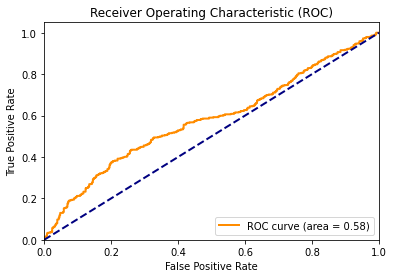

Metrics saved successfully


In [16]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 11s 200ms/step - loss: 0.6935 - accuracy: 0.5048 - val_loss: 0.6935 - val_accuracy: 0.4857
Epoch 2/100
53/53 [==============================] - 10s 196ms/step - loss: 0.6926 - accuracy: 0.5101 - val_loss: 0.6930 - val_accuracy: 0.4857
Epoch 3/100
53/53 [==============================] - 10s 191ms/step - loss: 0.6930 - accuracy: 0.5161 - val_loss: 0.6917 - val_accuracy: 0.5214
Epoch 4/100
53/53 [==============================] - 10s 191ms/step - loss: 0.6933 - accuracy: 0.5083 - val_loss: 0.6956 - val_accuracy: 0.4857
Epoch 5/100
53/53 [==============================] - 10s 191ms/step - loss: 0.6937 - accuracy: 0.5083 - val_loss: 0.6949 - val_accuracy: 0.4857
Epoch 6/100
53/53 [==============================] - 10s 192ms/step - loss: 0.6921 - accuracy: 0.5196 - val_loss: 0.6923 - val_accuracy: 0.4857
Epoch 7/100
53/53 [==============================] - 10s 191ms/step - loss: 0.6924 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy:

Validation Loss: 0.6916689276695251
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6919437050819397
Test Accuracy: 0.5177778005599976
Inference Time (Test set): 6.533952713012695 seconds
29/29 [==============================] - 4s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       461
           1       0.78      0.02      0.03       439

    accuracy                           0.52       900
   macro avg       0.65      0.51      0.36       900
weighted avg       0.64      0.52      0.36       900

Confusion Matrix:
[[459   2]
 [432   7]]


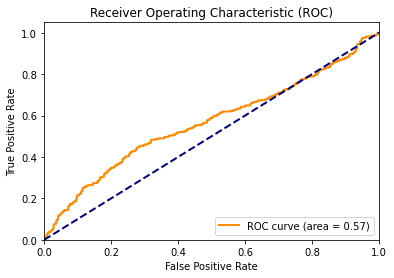

Metrics saved successfully


In [18]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [19]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 10s 196ms/step - loss: 0.6925 - accuracy: 0.5137 - val_loss: 0.6949 - val_accuracy: 0.4857
Epoch 2/150
53/53 [==============================] - 10s 194ms/step - loss: 0.6919 - accuracy: 0.5327 - val_loss: 0.6930 - val_accuracy: 0.4857
Epoch 3/150
53/53 [==============================] - 10s 192ms/step - loss: 0.6930 - accuracy: 0.5012 - val_loss: 0.6920 - val_accuracy: 0.4857
Epoch 4/150
53/53 [==============================] - 10s 195ms/step - loss: 0.6930 - accuracy: 0.4988 - val_loss: 0.6912 - val_accuracy: 0.5286
Epoch 5/150
53/53 [==============================] - 10s 195ms/step - loss: 0.6914 - accuracy: 0.5244 - val_loss: 0.6934 - val_accuracy: 0.4857
Epoch 6/150
53/53 [==============================] - 10s 195ms/step - loss: 0.6921 - accuracy: 0.5089 - val_loss: 0.7004 - val_accuracy: 0.4857
Epoch 7/150
53/53 [==============================] - 10s 195ms/step - loss: 0.6955 - accuracy: 0.4887 - val_loss: 0.6927 - val_accuracy:

Validation Loss: 0.69121915102005
Validation Accuracy: 0.5285714268684387
Test Loss: 0.6916220188140869
Test Accuracy: 0.5211111307144165
Inference Time (Test set): 6.5764079093933105 seconds
29/29 [==============================] - 4s 147ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68       461
           1       0.75      0.03      0.05       439

    accuracy                           0.52       900
   macro avg       0.63      0.51      0.37       900
weighted avg       0.63      0.52      0.37       900

Confusion Matrix:
[[457   4]
 [427  12]]


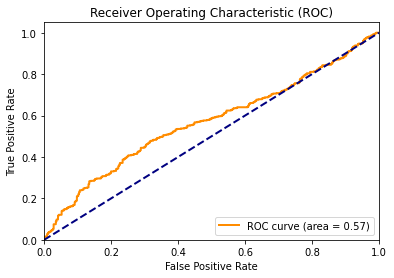

Metrics saved successfully


In [20]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")


In [21]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 10s 195ms/step - loss: 0.6927 - accuracy: 0.5107 - val_loss: 0.6939 - val_accuracy: 0.4857
Epoch 2/200
53/53 [==============================] - 10s 198ms/step - loss: 0.6916 - accuracy: 0.5185 - val_loss: 0.6921 - val_accuracy: 0.4857
Epoch 3/200
53/53 [==============================] - 11s 201ms/step - loss: 0.6938 - accuracy: 0.5018 - val_loss: 0.6920 - val_accuracy: 0.5167
Epoch 4/200
53/53 [==============================] - 11s 201ms/step - loss: 0.6919 - accuracy: 0.5351 - val_loss: 0.6939 - val_accuracy: 0.4857
Epoch 5/200
53/53 [==============================] - 11s 202ms/step - loss: 0.6942 - accuracy: 0.5089 - val_loss: 0.6927 - val_accuracy: 0.5167
Epoch 6/200
53/53 [==============================] - 10s 194ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6928 - val_accuracy: 0.5524
Epoch 7/200
53/53 [==============================] - 10s 192ms/step - loss: 0.6930 - accuracy: 0.4905 - val_loss: 0.6932 - val_accuracy:

Validation Loss: 0.6920152306556702
Validation Accuracy: 0.5166666507720947
Test Loss: 0.6922719478607178
Test Accuracy: 0.5111111402511597
Inference Time (Test set): 6.6101624965667725 seconds
29/29 [==============================] - 4s 147ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[460   1]
 [439   0]]


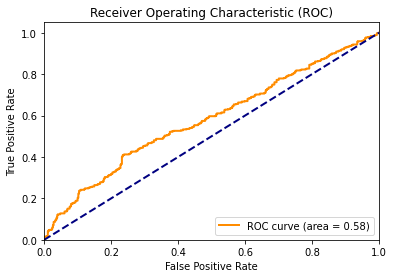

Metrics saved successfully


In [22]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a Conv2D layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(base_model.output)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dropout layer
x = Dropout(0.5)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [24]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 11s 202ms/step - loss: 0.7160 - accuracy: 0.5077 - val_loss: 0.6962 - val_accuracy: 0.4857
Epoch 2/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6951 - accuracy: 0.4952 - val_loss: 0.6944 - val_accuracy: 0.4857
Epoch 3/50
53/53 [==============================] - 10s 198ms/step - loss: 0.6929 - accuracy: 0.5363 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 4/50
53/53 [==============================] - 10s 197ms/step - loss: 0.6952 - accuracy: 0.4899 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 5/50
53/53 [==============================] - 10s 198ms/step - loss: 0.6932 - accuracy: 0.5143 - val_loss: 0.6948 - val_accuracy: 0.4857
Epoch 6/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6937 - val_accuracy: 0.4857
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy: 0.4857

Validation Loss: 0.6932799816131592
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6932621002197266
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.6744654178619385 seconds
29/29 [==============================] - 5s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


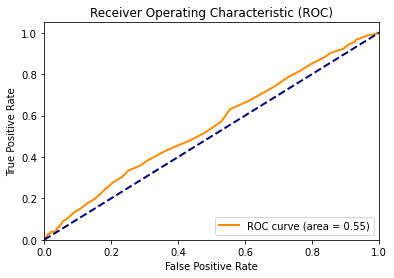

Metrics saved successfully


In [25]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [26]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 11s 204ms/step - loss: 0.6934 - accuracy: 0.5030 - val_loss: 0.6942 - val_accuracy: 0.4857
Epoch 2/100
53/53 [==============================] - 11s 199ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6944 - val_accuracy: 0.4857
Epoch 3/100
53/53 [==============================] - 11s 199ms/step - loss: 0.6936 - accuracy: 0.5101 - val_loss: 0.6938 - val_accuracy: 0.4857
Epoch 4/100
53/53 [==============================] - 10s 196ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6941 - val_accuracy: 0.4857
Epoch 5/100
53/53 [==============================] - 10s 197ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6943 - val_accuracy: 0.4857
Epoch 6/100
53/53 [==============================] - 10s 197ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6943 - val_accuracy: 0.4857
Epoch 7/100
53/53 [==============================] - 10s 196ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6942 - val_accuracy:

Validation Loss: 0.6937736868858337
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6937039494514465
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.608411550521851 seconds
29/29 [==============================] - 4s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


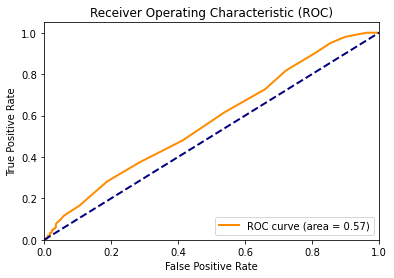

Metrics saved successfully


In [27]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [28]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 10s 197ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6937 - val_accuracy: 0.4857
Epoch 2/150
53/53 [==============================] - 10s 196ms/step - loss: 0.6933 - accuracy: 0.5101 - val_loss: 0.6934 - val_accuracy: 0.4857
Epoch 3/150
53/53 [==============================] - 10s 196ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6937 - val_accuracy: 0.4857
Epoch 4/150
53/53 [==============================] - 10s 196ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6942 - val_accuracy: 0.4857
Epoch 5/150
53/53 [==============================] - 10s 196ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6941 - val_accuracy: 0.4857
Epoch 6/150
53/53 [==============================] - 11s 205ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy: 0.4857
Epoch 7/150
53/53 [==============================] - 11s 209ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6936 - val_accuracy:

Validation Loss: 0.6933891177177429
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6933582425117493
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.694694995880127 seconds
29/29 [==============================] - 4s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


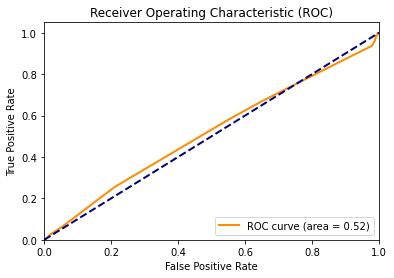

Metrics saved successfully


In [29]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [30]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 11s 199ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6936 - val_accuracy: 0.4857
Epoch 2/200
53/53 [==============================] - 11s 200ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6941 - val_accuracy: 0.4857
Epoch 3/200
53/53 [==============================] - 10s 196ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy: 0.4857
Epoch 4/200
53/53 [==============================] - 11s 199ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy: 0.4857
Epoch 5/200
53/53 [==============================] - 11s 202ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6942 - val_accuracy: 0.4857
Epoch 6/200
53/53 [==============================] - 11s 202ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6935 - val_accuracy: 0.4857
Epoch 7/200
53/53 [==============================] - 10s 197ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy:

Validation Loss: 0.6935040354728699
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6934605836868286
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.725903749465942 seconds
29/29 [==============================] - 4s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


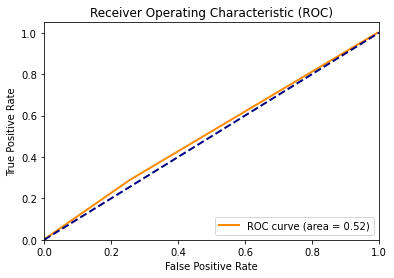

Metrics saved successfully


In [31]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+LSTM+Dense

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape,Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)  # You need to define the input shape

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Reshape the flattened output to include the time steps dimension
x = Reshape((1, -1))(x)  # Assuming each sample represents a single time step

# Add LSTM layer
x = LSTM(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)


# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [37]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 18s 324ms/step - loss: 0.7148 - accuracy: 0.5054 - val_loss: 0.6942 - val_accuracy: 0.5143
Epoch 2/50
53/53 [==============================] - 17s 320ms/step - loss: 0.7001 - accuracy: 0.5077 - val_loss: 0.7061 - val_accuracy: 0.4857
Epoch 3/50
53/53 [==============================] - 17s 327ms/step - loss: 0.7018 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4857
Epoch 4/50
53/53 [==============================] - 17s 328ms/step - loss: 0.6978 - accuracy: 0.4827 - val_loss: 0.6947 - val_accuracy: 0.4857
Epoch 5/50
53/53 [==============================] - 17s 321ms/step - loss: 0.6962 - accuracy: 0.5065 - val_loss: 0.6940 - val_accuracy: 0.4857
Epoch 6/50
53/53 [==============================] - 17s 324ms/step - loss: 0.6949 - accuracy: 0.4911 - val_loss: 0.6934 - val_accuracy: 0.4857
Epoch 7/50
53/53 [==============================] - 17s 327ms/step - loss: 0.6950 - accuracy: 0.5018 - val_loss: 0.7195 - val_accuracy: 0.4857

Validation Loss: 0.6930346488952637
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6930522322654724
Test Accuracy: 0.5122222304344177
Inference Time (Test set): 6.748039722442627 seconds
29/29 [==============================] - 5s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[461   0]
 [439   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


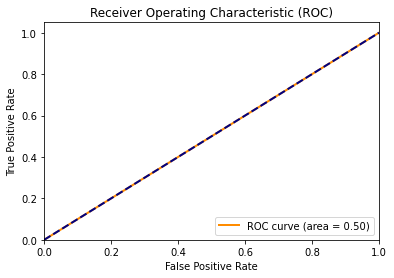

Metrics saved successfully


In [39]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score
import pandas as pd
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [40]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 17s 328ms/step - loss: 0.6942 - accuracy: 0.5006 - val_loss: 0.6960 - val_accuracy: 0.4857
Epoch 2/100
53/53 [==============================] - 17s 326ms/step - loss: 0.6949 - accuracy: 0.4899 - val_loss: 0.6940 - val_accuracy: 0.4857
Epoch 3/100
53/53 [==============================] - 17s 326ms/step - loss: 0.6963 - accuracy: 0.5089 - val_loss: 0.6936 - val_accuracy: 0.4857
Epoch 4/100
53/53 [==============================] - 17s 326ms/step - loss: 0.6957 - accuracy: 0.4911 - val_loss: 0.6946 - val_accuracy: 0.4857
Epoch 5/100
53/53 [==============================] - 17s 326ms/step - loss: 0.6953 - accuracy: 0.5030 - val_loss: 0.7003 - val_accuracy: 0.4857
Epoch 6/100
53/53 [==============================] - 17s 325ms/step - loss: 0.6958 - accuracy: 0.4899 - val_loss: 0.6964 - val_accuracy: 0.4857
Epoch 7/100
53/53 [==============================] - 17s 326ms/step - loss: 0.6950 - accuracy: 0.4863 - val_loss: 0.6929 - val_accuracy:

Validation Loss: 0.6928734183311462
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6929237842559814
Test Accuracy: 0.5122222304344177
Inference Time (Test set): 6.763563394546509 seconds
29/29 [==============================] - 5s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[461   0]
 [439   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


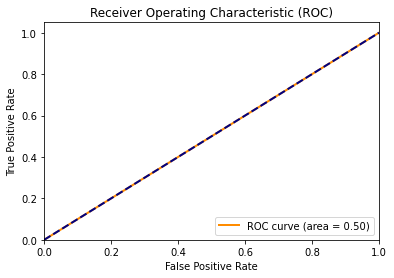

Metrics saved successfully


In [41]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [42]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 17s 328ms/step - loss: 0.6942 - accuracy: 0.5077 - val_loss: 0.6936 - val_accuracy: 0.5143
Epoch 2/150
53/53 [==============================] - 17s 326ms/step - loss: 0.6973 - accuracy: 0.4875 - val_loss: 0.6959 - val_accuracy: 0.4857
Epoch 3/150
53/53 [==============================] - 17s 326ms/step - loss: 0.6947 - accuracy: 0.4935 - val_loss: 0.6927 - val_accuracy: 0.5143
Epoch 4/150
53/53 [==============================] - 17s 326ms/step - loss: 0.6947 - accuracy: 0.4923 - val_loss: 0.6936 - val_accuracy: 0.4857
Epoch 5/150
53/53 [==============================] - 17s 326ms/step - loss: 0.6943 - accuracy: 0.4887 - val_loss: 0.6955 - val_accuracy: 0.4857
Epoch 6/150
53/53 [==============================] - 17s 326ms/step - loss: 0.6936 - accuracy: 0.5113 - val_loss: 0.6929 - val_accuracy: 0.5143
Epoch 7/150
53/53 [==============================] - 17s 325ms/step - loss: 0.6938 - accuracy: 0.4958 - val_loss: 0.6944 - val_accuracy:

Validation Loss: 0.6927473545074463
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6928824782371521
Test Accuracy: 0.5122222304344177
Inference Time (Test set): 6.728971481323242 seconds
29/29 [==============================] - 5s 155ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[461   0]
 [439   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


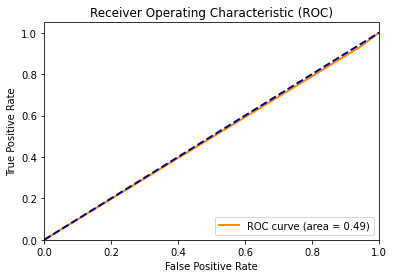

Metrics saved successfully


In [43]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [44]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 17s 328ms/step - loss: 0.6954 - accuracy: 0.4851 - val_loss: 0.6936 - val_accuracy: 0.4857
Epoch 2/200
53/53 [==============================] - 17s 326ms/step - loss: 0.6936 - accuracy: 0.4899 - val_loss: 0.7009 - val_accuracy: 0.4857
Epoch 3/200
53/53 [==============================] - 17s 331ms/step - loss: 0.6947 - accuracy: 0.4935 - val_loss: 0.6949 - val_accuracy: 0.4857
Epoch 4/200
53/53 [==============================] - 17s 326ms/step - loss: 0.6950 - accuracy: 0.4887 - val_loss: 0.6927 - val_accuracy: 0.5143
Epoch 5/200
53/53 [==============================] - 17s 326ms/step - loss: 0.6940 - accuracy: 0.4982 - val_loss: 0.6938 - val_accuracy: 0.4857
Epoch 6/200
53/53 [==============================] - 17s 326ms/step - loss: 0.6937 - accuracy: 0.4994 - val_loss: 0.6941 - val_accuracy: 0.4857
Epoch 7/200
53/53 [==============================] - 17s 326ms/step - loss: 0.6939 - accuracy: 0.5042 - val_loss: 0.6951 - val_accuracy:

Validation Loss: 0.6927391290664673
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6928548216819763
Test Accuracy: 0.5122222304344177
Inference Time (Test set): 6.7483439445495605 seconds
29/29 [==============================] - 5s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[461   0]
 [439   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


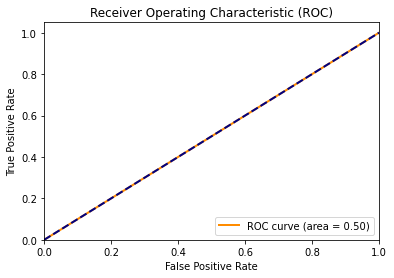

Metrics saved successfully


In [45]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+GRU+Dense

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Flatten, Reshape  # Import Reshape layer
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Flatten layer to convert 4D tensor to 2D tensor
x = Flatten()(base_model.output)

# Reshape the flattened output to have the appropriate shape
x = Reshape((7, 7 * 1024))(x)

# Add GRU layer
x = GRU(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [48]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 12s 211ms/step - loss: 0.7297 - accuracy: 0.4946 - val_loss: 0.7163 - val_accuracy: 0.4857
Epoch 2/50
53/53 [==============================] - 11s 204ms/step - loss: 0.6993 - accuracy: 0.4982 - val_loss: 0.7211 - val_accuracy: 0.4857
Epoch 3/50
53/53 [==============================] - 11s 207ms/step - loss: 0.7004 - accuracy: 0.5113 - val_loss: 0.7148 - val_accuracy: 0.5143
Epoch 4/50
53/53 [==============================] - 11s 208ms/step - loss: 0.7019 - accuracy: 0.4994 - val_loss: 0.7370 - val_accuracy: 0.4857
Epoch 5/50
53/53 [==============================] - 11s 211ms/step - loss: 0.6992 - accuracy: 0.4863 - val_loss: 0.7422 - val_accuracy: 0.4857
Epoch 6/50
53/53 [==============================] - 11s 215ms/step - loss: 0.7004 - accuracy: 0.5030 - val_loss: 0.7008 - val_accuracy: 0.5143
Epoch 7/50
53/53 [==============================] - 11s 214ms/step - loss: 0.6998 - accuracy: 0.4720 - val_loss: 0.6946 - val_accuracy: 0.4857

Validation Loss: 0.6933833360671997
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6933531165122986
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.594198942184448 seconds
29/29 [==============================] - 5s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


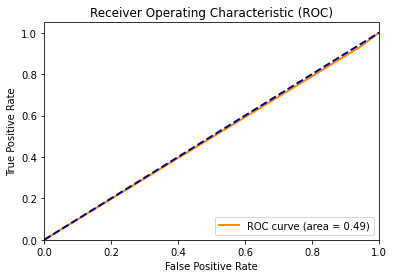

Metrics saved successfully


In [49]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [50]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 11s 214ms/step - loss: 0.7023 - accuracy: 0.5089 - val_loss: 0.6934 - val_accuracy: 0.4857
Epoch 2/100
53/53 [==============================] - 11s 213ms/step - loss: 0.7177 - accuracy: 0.4815 - val_loss: 0.6973 - val_accuracy: 0.4857
Epoch 3/100
53/53 [==============================] - 11s 213ms/step - loss: 0.7126 - accuracy: 0.5077 - val_loss: 0.7004 - val_accuracy: 0.4857
Epoch 4/100
53/53 [==============================] - 11s 212ms/step - loss: 0.7015 - accuracy: 0.4863 - val_loss: 0.6964 - val_accuracy: 0.4857
Epoch 5/100
53/53 [==============================] - 11s 213ms/step - loss: 0.6967 - accuracy: 0.4815 - val_loss: 0.6939 - val_accuracy: 0.4857
Epoch 6/100
53/53 [==============================] - 11s 213ms/step - loss: 0.7001 - accuracy: 0.4911 - val_loss: 0.7020 - val_accuracy: 0.4857
Training Time: 67.77828764915466 seconds


Validation Loss: 0.6933613419532776
Validation Accuracy: 0.48571428656578064
Test Loss: 0.693333625793457
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.613017559051514 seconds
29/29 [==============================] - 5s 156ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


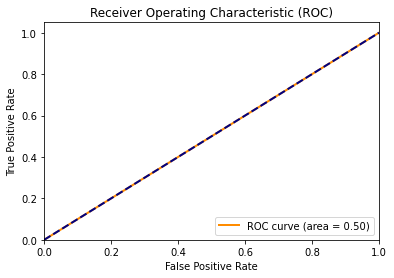

Metrics saved successfully


In [51]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [52]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 11s 216ms/step - loss: 0.6988 - accuracy: 0.4875 - val_loss: 0.6939 - val_accuracy: 0.5143
Epoch 2/150
53/53 [==============================] - 11s 212ms/step - loss: 0.7030 - accuracy: 0.4887 - val_loss: 0.7404 - val_accuracy: 0.4857
Epoch 3/150
53/53 [==============================] - 11s 212ms/step - loss: 0.7032 - accuracy: 0.5018 - val_loss: 0.6935 - val_accuracy: 0.4857
Epoch 4/150
53/53 [==============================] - 11s 212ms/step - loss: 0.6967 - accuracy: 0.4911 - val_loss: 0.6938 - val_accuracy: 0.4857
Epoch 5/150
53/53 [==============================] - 11s 213ms/step - loss: 0.6947 - accuracy: 0.5101 - val_loss: 0.6928 - val_accuracy: 0.5143
Epoch 6/150
53/53 [==============================] - 11s 213ms/step - loss: 0.6947 - accuracy: 0.5054 - val_loss: 0.6986 - val_accuracy: 0.5143
Epoch 7/150
53/53 [==============================] - 11s 212ms/step - loss: 0.6994 - accuracy: 0.5065 - val_loss: 0.7260 - val_accuracy:

Validation Loss: 0.6928316354751587
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6930059194564819
Test Accuracy: 0.5122222304344177
Inference Time (Test set): 6.5938966274261475 seconds
29/29 [==============================] - 4s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[461   0]
 [439   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


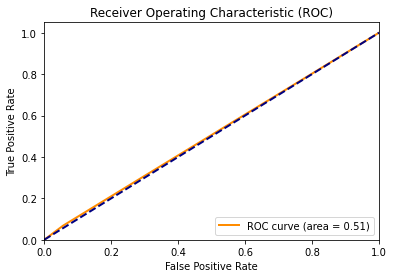

Metrics saved successfully


In [53]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [54]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 11s 214ms/step - loss: 0.6965 - accuracy: 0.4863 - val_loss: 0.7057 - val_accuracy: 0.4857
Epoch 2/200
53/53 [==============================] - 11s 213ms/step - loss: 0.6967 - accuracy: 0.5054 - val_loss: 0.6967 - val_accuracy: 0.5143
Epoch 3/200
53/53 [==============================] - 11s 212ms/step - loss: 0.7000 - accuracy: 0.4768 - val_loss: 0.6935 - val_accuracy: 0.4857
Epoch 4/200
53/53 [==============================] - 11s 212ms/step - loss: 0.6955 - accuracy: 0.4899 - val_loss: 0.6956 - val_accuracy: 0.4857
Epoch 5/200
53/53 [==============================] - 11s 212ms/step - loss: 0.6975 - accuracy: 0.4970 - val_loss: 0.6979 - val_accuracy: 0.5143
Epoch 6/200
53/53 [==============================] - 11s 212ms/step - loss: 0.6995 - accuracy: 0.4744 - val_loss: 0.6943 - val_accuracy: 0.4857
Epoch 7/200
53/53 [==============================] - 11s 212ms/step - loss: 0.6997 - accuracy: 0.4804 - val_loss: 0.6944 - val_accuracy:

Validation Loss: 0.6934675574302673
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6934279203414917
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.611781597137451 seconds
29/29 [==============================] - 4s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


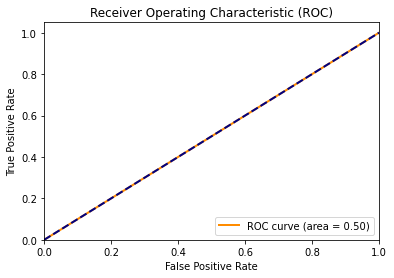

Metrics saved successfully


In [55]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Attention Mechanism+Dense

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Reshape, Permute, Multiply
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
attention_probs = Dense(1, activation='softmax')(base_model.output)
attention_mul = Multiply()([base_model.output, attention_probs])

# Add a global average pooling layer
x = GlobalAveragePooling2D()(attention_mul)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

In [58]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 11s 189ms/step - loss: 0.7218 - accuracy: 0.4887 - val_loss: 0.6999 - val_accuracy: 0.4857
Epoch 2/50
53/53 [==============================] - 10s 183ms/step - loss: 0.7035 - accuracy: 0.5101 - val_loss: 0.7030 - val_accuracy: 0.5143
Epoch 3/50
53/53 [==============================] - 10s 185ms/step - loss: 0.7034 - accuracy: 0.5208 - val_loss: 0.6940 - val_accuracy: 0.4857
Epoch 4/50
53/53 [==============================] - 10s 189ms/step - loss: 0.7076 - accuracy: 0.5030 - val_loss: 0.7209 - val_accuracy: 0.5143
Epoch 5/50
53/53 [==============================] - 10s 188ms/step - loss: 0.7058 - accuracy: 0.5054 - val_loss: 0.6990 - val_accuracy: 0.5143
Epoch 6/50
53/53 [==============================] - 10s 192ms/step - loss: 0.6971 - accuracy: 0.4946 - val_loss: 0.6973 - val_accuracy: 0.4857
Epoch 7/50
53/53 [==============================] - 10s 194ms/step - loss: 0.7183 - accuracy: 0.5054 - val_loss: 0.7621 - val_accuracy: 0.4857

Validation Loss: 0.6939504742622375
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6938653588294983
Test Accuracy: 0.4877777695655823
Inference Time (Test set): 6.564697265625 seconds
29/29 [==============================] - 5s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

Confusion Matrix:
[[  0 461]
 [  0 439]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


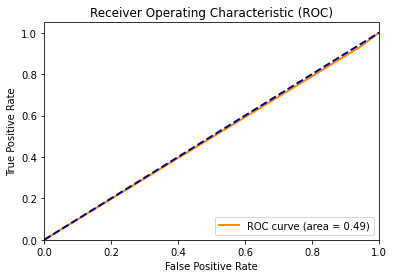

Metrics saved successfully


In [59]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [60]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 10s 195ms/step - loss: 0.7033 - accuracy: 0.5006 - val_loss: 0.7092 - val_accuracy: 0.4857
Epoch 2/100
53/53 [==============================] - 10s 194ms/step - loss: 0.6988 - accuracy: 0.4887 - val_loss: 0.6989 - val_accuracy: 0.4857
Epoch 3/100
53/53 [==============================] - 10s 193ms/step - loss: 0.6960 - accuracy: 0.5268 - val_loss: 0.7783 - val_accuracy: 0.5143
Epoch 4/100
53/53 [==============================] - 10s 193ms/step - loss: 0.7165 - accuracy: 0.5054 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 5/100
53/53 [==============================] - 10s 193ms/step - loss: 0.7038 - accuracy: 0.4851 - val_loss: 0.7293 - val_accuracy: 0.4857
Epoch 6/100
53/53 [==============================] - 10s 193ms/step - loss: 0.7020 - accuracy: 0.5065 - val_loss: 0.6929 - val_accuracy: 0.5143
Epoch 7/100
53/53 [==============================] - 10s 193ms/step - loss: 0.6943 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy:

Validation Loss: 0.6927441358566284
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6928753852844238
Test Accuracy: 0.5122222304344177
Inference Time (Test set): 6.5467164516448975 seconds
29/29 [==============================] - 4s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

Confusion Matrix:
[[461   0]
 [439   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


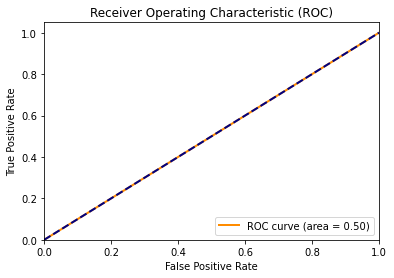

Metrics saved successfully


In [61]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 11s 192ms/step - loss: 0.7285 - accuracy: 0.5173 - val_loss: 0.7069 - val_accuracy: 0.5143
Epoch 2/150
53/53 [==============================] - 10s 185ms/step - loss: 0.7011 - accuracy: 0.5125 - val_loss: 0.7000 - val_accuracy: 0.5143
Epoch 3/150
53/53 [==============================] - 10s 190ms/step - loss: 0.6979 - accuracy: 0.5250 - val_loss: 0.7228 - val_accuracy: 0.4857
Epoch 4/150
53/53 [==============================] - 10s 190ms/step - loss: 0.7045 - accuracy: 0.5173 - val_loss: 0.7208 - val_accuracy: 0.5143
Epoch 5/150
53/53 [==============================] - 10s 188ms/step - loss: 0.7054 - accuracy: 0.5244 - val_loss: 0.6947 - val_accuracy: 0.4857
Epoch 6/150
53/53 [==============================] - 10s 187ms/step - loss: 0.6937 - accuracy: 0.5274 - val_loss: 0.7122 - val_accuracy: 0.5167
Epoch 7/150
53/53 [==============================] - 10s 192ms/step - loss: 0.6916 - accuracy: 0.5351 - val_loss: 0.6905 - val_accuracy:

Validation Loss: 0.676677405834198
Validation Accuracy: 0.5857142806053162
Test Loss: 0.6772255897521973
Test Accuracy: 0.5777778029441833
Inference Time (Test set): 6.426295518875122 seconds
29/29 [==============================] - 4s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.78      0.65       461
           1       0.61      0.37      0.46       439

    accuracy                           0.58       900
   macro avg       0.59      0.57      0.56       900
weighted avg       0.59      0.58      0.56       900

Confusion Matrix:
[[358 103]
 [277 162]]


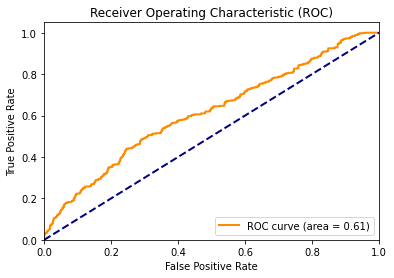

Metrics saved successfully


In [12]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 11s 199ms/step - loss: 0.6834 - accuracy: 0.5560 - val_loss: 0.6886 - val_accuracy: 0.4881
Epoch 2/200
53/53 [==============================] - 10s 197ms/step - loss: 0.6757 - accuracy: 0.5738 - val_loss: 0.6950 - val_accuracy: 0.4857
Epoch 3/200
53/53 [==============================] - 10s 197ms/step - loss: 0.6786 - accuracy: 0.5643 - val_loss: 0.6941 - val_accuracy: 0.5548
Epoch 4/200
53/53 [==============================] - 10s 197ms/step - loss: 0.6880 - accuracy: 0.5452 - val_loss: 0.6759 - val_accuracy: 0.5762
Epoch 5/200
53/53 [==============================] - 10s 195ms/step - loss: 0.6789 - accuracy: 0.5714 - val_loss: 0.6788 - val_accuracy: 0.5381
Epoch 6/200
53/53 [==============================] - 10s 192ms/step - loss: 0.6765 - accuracy: 0.5601 - val_loss: 0.6730 - val_accuracy: 0.5810
Epoch 7/200
53/53 [==============================] - 10s 192ms/step - loss: 0.6749 - accuracy: 0.5720 - val_loss: 0.6725 - val_accuracy:

Validation Loss: 0.672485888004303
Validation Accuracy: 0.5785714387893677
Test Loss: 0.6730566024780273
Test Accuracy: 0.5711110830307007
Inference Time (Test set): 6.52233362197876 seconds
29/29 [==============================] - 4s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.84      0.67       461
           1       0.63      0.29      0.40       439

    accuracy                           0.57       900
   macro avg       0.59      0.56      0.53       900
weighted avg       0.59      0.57      0.54       900

Confusion Matrix:
[[386  75]
 [311 128]]


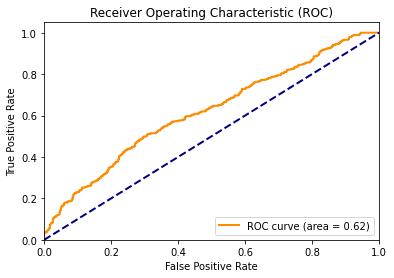

Metrics saved successfully


In [14]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Capsule Network+Dense

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import pandas as pd

# Start time
start_time = time.time()

# Assume X_train, X_test, y_train, y_test are available

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of MobileNet

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j


# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 1024))(x)  # Reshape to 3D tensor for Capsule Network
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # Use softmax activation for multi-class classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 11s 190ms/step - loss: 0.5737 - accuracy: 0.7167 - val_loss: 0.5536 - val_accuracy: 0.7167
Epoch 2/50
53/53 [==============================] - 10s 182ms/step - loss: 0.4148 - accuracy: 0.8107 - val_loss: 0.4404 - val_accuracy: 0.7929
Epoch 3/50
53/53 [==============================] - 10s 188ms/step - loss: 0.3384 - accuracy: 0.8476 - val_loss: 0.4425 - val_accuracy: 0.7929
Epoch 4/50
53/53 [==============================] - 10s 189ms/step - loss: 0.3026 - accuracy: 0.8655 - val_loss: 0.3523 - val_accuracy: 0.8333
Epoch 5/50
53/53 [==============================] - 10s 188ms/step - loss: 0.2532 - accuracy: 0.8833 - val_loss: 0.3362 - val_accuracy: 0.8381
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.2437 - accuracy: 0.8899 - val_loss: 0.3993 - val_accuracy: 0.8310
Epoch 7/50
53/53 [==============================] - 10s 195ms/step - loss: 0.2271 - accuracy: 0.9083 - val_loss: 0.3622 - val_accuracy: 0.8500

Validation Loss: 0.3361881375312805
Validation Accuracy: 0.8380952477455139
Test Loss: 0.2994363009929657
Test Accuracy: 0.8655555844306946
Inference Time (Test set): 6.6098878383636475 seconds
29/29 [==============================] - 5s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87       461
           1       0.90      0.81      0.85       439

    accuracy                           0.87       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.87      0.87       900

Confusion Matrix:
[[423  38]
 [ 83 356]]


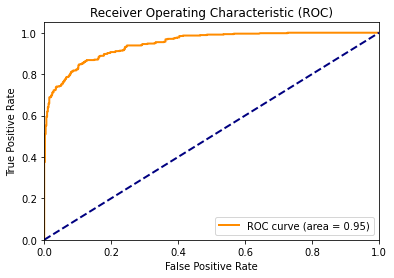

Metrics saved successfully


In [7]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 10s 196ms/step - loss: 0.2263 - accuracy: 0.9042 - val_loss: 0.3517 - val_accuracy: 0.8500
Epoch 2/100
53/53 [==============================] - 10s 195ms/step - loss: 0.1970 - accuracy: 0.9208 - val_loss: 0.3288 - val_accuracy: 0.8476
Epoch 3/100
53/53 [==============================] - 10s 193ms/step - loss: 0.2157 - accuracy: 0.9060 - val_loss: 0.3317 - val_accuracy: 0.8548
Epoch 4/100
53/53 [==============================] - 10s 194ms/step - loss: 0.1752 - accuracy: 0.9304 - val_loss: 0.3447 - val_accuracy: 0.8500
Epoch 5/100
53/53 [==============================] - 10s 194ms/step - loss: 0.1848 - accuracy: 0.9196 - val_loss: 0.3397 - val_accuracy: 0.8524
Epoch 6/100
53/53 [==============================] - 10s 194ms/step - loss: 0.1742 - accuracy: 0.9286 - val_loss: 0.5537 - val_accuracy: 0.8095
Epoch 7/100
53/53 [==============================] - 10s 194ms/step - loss: 0.1747 - accuracy: 0.9280 - val_loss: 0.3827 - val_accuracy:

Validation Loss: 0.3287738263607025
Validation Accuracy: 0.8476190567016602
Test Loss: 0.28863760828971863
Test Accuracy: 0.8688889145851135
Inference Time (Test set): 6.578816890716553 seconds
29/29 [==============================] - 4s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.86       461
           1       0.83      0.92      0.87       439

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900

Confusion Matrix:
[[378  83]
 [ 35 404]]


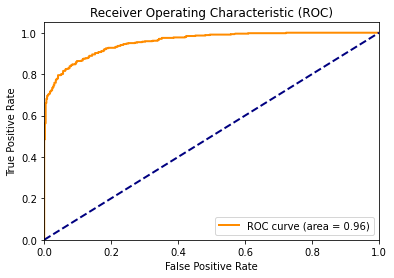

Metrics saved successfully


In [9]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 10s 196ms/step - loss: 0.1892 - accuracy: 0.9214 - val_loss: 0.3546 - val_accuracy: 0.8548
Epoch 2/150
53/53 [==============================] - 10s 194ms/step - loss: 0.1364 - accuracy: 0.9446 - val_loss: 0.3763 - val_accuracy: 0.8524
Epoch 3/150
53/53 [==============================] - 10s 195ms/step - loss: 0.1806 - accuracy: 0.9256 - val_loss: 0.4521 - val_accuracy: 0.8024
Epoch 4/150
53/53 [==============================] - 10s 195ms/step - loss: 0.1650 - accuracy: 0.9310 - val_loss: 0.3790 - val_accuracy: 0.8476
Epoch 5/150
53/53 [==============================] - 10s 194ms/step - loss: 0.1059 - accuracy: 0.9554 - val_loss: 0.4465 - val_accuracy: 0.8524
Epoch 6/150
53/53 [==============================] - 10s 195ms/step - loss: 0.0937 - accuracy: 0.9637 - val_loss: 0.4510 - val_accuracy: 0.8548
Training Time: 62.81103229522705 seconds


Validation Loss: 0.3545681834220886
Validation Accuracy: 0.8547618985176086
Test Loss: 0.27478647232055664
Test Accuracy: 0.8888888955116272
Inference Time (Test set): 6.715815305709839 seconds
29/29 [==============================] - 4s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       461
           1       0.89      0.88      0.89       439

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900

Confusion Matrix:
[[413  48]
 [ 52 387]]


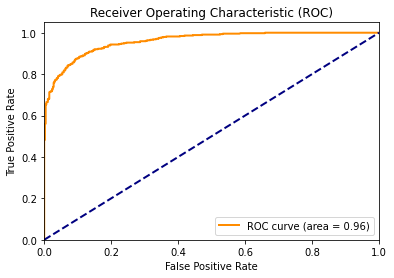

Metrics saved successfully


In [11]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 11s 200ms/step - loss: 0.1542 - accuracy: 0.9369 - val_loss: 0.3822 - val_accuracy: 0.8405
Epoch 2/200
53/53 [==============================] - 10s 194ms/step - loss: 0.2083 - accuracy: 0.9018 - val_loss: 0.5538 - val_accuracy: 0.8214
Epoch 3/200
53/53 [==============================] - 10s 195ms/step - loss: 0.1399 - accuracy: 0.9429 - val_loss: 0.3905 - val_accuracy: 0.8548
Epoch 4/200
53/53 [==============================] - 10s 195ms/step - loss: 0.1298 - accuracy: 0.9470 - val_loss: 0.4046 - val_accuracy: 0.8500
Epoch 5/200
53/53 [==============================] - 10s 195ms/step - loss: 0.1169 - accuracy: 0.9482 - val_loss: 0.5178 - val_accuracy: 0.8429
Epoch 6/200
53/53 [==============================] - 10s 194ms/step - loss: 0.1105 - accuracy: 0.9542 - val_loss: 0.4351 - val_accuracy: 0.8524
Training Time: 63.73476552963257 seconds


Validation Loss: 0.3821747601032257
Validation Accuracy: 0.8404762148857117
Test Loss: 0.339248925447464
Test Accuracy: 0.8611111044883728
Inference Time (Test set): 6.611847400665283 seconds
29/29 [==============================] - 4s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       461
           1       0.82      0.92      0.87       439

    accuracy                           0.86       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.86      0.86       900

Confusion Matrix:
[[369  92]
 [ 33 406]]


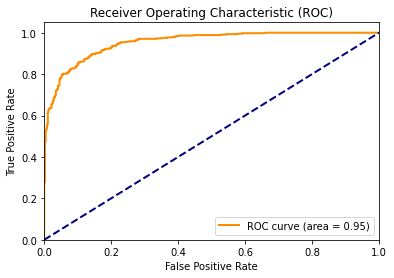

Metrics saved successfully


In [13]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")